In [8]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import QUANTAXIS as QA

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat

import EAST.Fetcher_EM as east

from base.JuUnits import excute_for_multidates

In [79]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2016'
year2 = '2019'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [139]:
# df_all1 = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all2 = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all = pd.concat([df_all1,df_all2],axis=0).sort_index()

data_ = df_all

year1 = '2016'
year2 = '2022'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [140]:
# 个股情绪

# turnover = data_['volume'] / (data_['lshares'] *100) 

# turnover_mean_month = excute_for_multidates(turnover, lambda x:x.rolling(22).mean(), level='code')
# turnover_mean_week = excute_for_multidates(turnover, lambda x:x.rolling(5).mean(), level='code')
# turnover_unknown = turnover_mean_week/turnover_mean_month

# overnight_ret = excute_for_multidates(data_, lambda x:(x['open']/x['close'].shift(1))-1, level='code')
# turnover_rate = excute_for_multidates(turnover, lambda x: x-x.shift(1), level='code')
# # 指令不平衡(净流入额/总成交额)  代理达成一致意见所需时间
# buy_sell_belance = intraday_df_tmp['bs_balance']

# ret = smpl.get_current_return(data_, 'close')
# ret_std5 = excute_for_multidates(ret, lambda x:x.rolling(5).std(), level='code')

def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        rs = float(x.shape[0])
    else:
        up = (x>0).sum()
        rs = up/down
    rsi=100-100/(1+rs)
    return rsi
    
# *投资者达成一致意见所需时间 = (最高价 - 开盘价) / (收盘价 - 开盘价)
# *相对强弱指标（RSI）：计算公式：RSI=100-100/(1+RS)
   # 相对强度(RS)=一定时期收盘指数涨数的平均值/一定时期收盘指数跌数的平均值，主要和价格的收盘平均值有关，可以表现股价的运动速率。

# RSI_6 = excute_for_multidates(ret, lambda x:x.rolling(6).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_12 = excute_for_multidates(ret, lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_CD = RS_6-RS_12

# *随机指标（KD）
# C为当天的收；
# UP:=HHV(H,20);
# DN:=LLV(L,20);
# RSV:=(C-DN)/(UP-DN)*100;
# K:SMA(RSV,3,1);
# D:SMA(K,3,1);

def calc_kd(df):
    up = df.high.rolling(20).max()
    dn = df.low.rolling(20).min()
    c = df.close
    rsv = (c-dn)/(up-dn) * 100
    return rsv
    
KD = excute_for_multidates(data_, lambda xs:calc_kd(xs), level='code')



# volume





In [141]:
# KD[20:60]

In [142]:
# RSI_CD[24200:24260]

In [143]:
def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        return float(x.shape[0])
    else:
        up = (x>0).sum()
        return up/down
    
excute_for_multidates(ret.loc[(slice(None),'000002'),], lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')

NameError: name 'ret' is not defined

In [ ]:
def get_intraday_indicator_by_code(code,st='2016-03-01',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
    def calc(varaints_daily):
        close = varaints_daily.close
        ret = (close/close.shift(1) - 1)#.dropna()
        #######指令平衡###########################
        #已实现方差 RealizedVolatility
        net_mf_amount = varaints_daily.amount[ret > 0].sum()
        neg_amount = varaints_daily.amount[ret < 0].sum()
        amount = neg_amount+net_mf_amount
        if amount == 0:
            bs_balance = 0
        else:
            bs_balance = (net_mf_amount/amount)-0.5
        ##########################################
        
        
        # print()
        return bs_balance

    stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
    if stock_df is None:
        return None
    stock_df = stock_df.data
    columns = ['close','volume','amount']
    var = stock_df[columns]
    var_unindex = var.reset_index()

    res = var_unindex[columns].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc(x))
    res_df = pd.DataFrame(res.to_list(),
                          index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),
                          columns=['bs_balance'])
    
    return res_df

intraday_df_tmp = pd.DataFrame()
for code in ['002415']:
    res = get_intraday_indicator_by_code(code,dates.min().strftime('%Y-%m-%d'),dates.max().strftime('%Y-%m-%d'))
    if res is None:
        continue
    intraday_df_tmp = pd.concat([intraday_df_tmp,res],axis=0)

In [ ]:
# a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
# a = turnover_unknown.loc[(slice(None),'000001')]
a = KD.loc[(slice(None),'000002'),]
d = a.index.get_level_values(0).unique()
# bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data
bench = data_.loc[(slice(None),'000002'),]

In [ ]:
fig = plt.figure(figsize=(1420/72,320/72))
# a['close'].groupby(level=1).apply(lambda x:x.plot())
a.plot()
# ax2 = plt.gca()
# ax2.plot(range(bench.shape[0]),(0.5*a['close'].loc[(slice(None),'880876')].values+0.5*a['close'].loc[(slice(None),'880877')]).values,linewidth=2,color="red")



ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [ ]:
data_

In [ ]:
a.corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880811')]).corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880008')]).corr(a['close'].loc[(slice(None),'880018')])

In [ ]:
a

In [ ]:
a['close'].loc[(slice(None),'880780')]

In [ ]:
# 市场情绪
# n=east.fetch_north_deal_day(direct='north_', start=dates.min(), end=dates.max()).data
# s=east.fetch_north_deal_day(direct='south_', start=dates.min(), end=dates.max()).data
#~ 880780 融资增加 2019开始
#~ 880792 基金增仓 2020
#~ 880793 基金减仓 2020
#~ 880751 昨日跌停# 880863  昨日涨停 # 880876 户数增加 # 880877 户数减少
#~ 880752 昨曾跌停# 880874  昨曾涨停
#~ 880008 全Ａ等权
#~ 880018 主板等权


# 880990 TDX 金融 
# 880005 涨跌家数 收=涨数，开=跌数
# 880006 停板家数 收=涨停数，开=跌停数，高=最大涨停数

# 4.简易市场情绪
# 每日涨停/跌停数

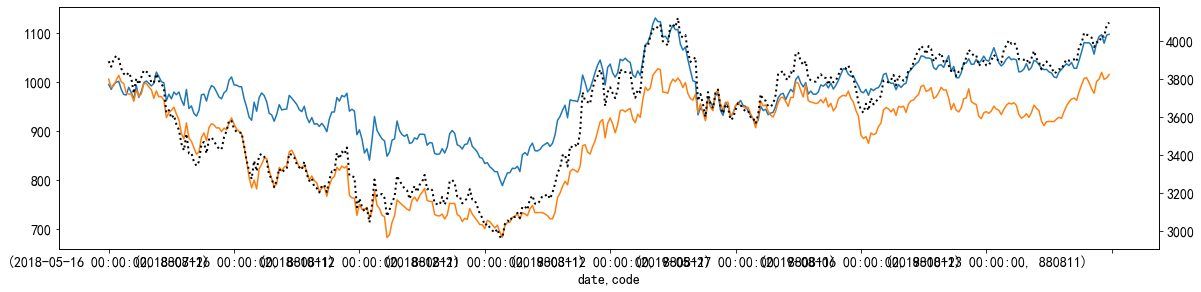

In [161]:
a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
d = a.index.get_level_values(0).unique()
bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data

fig = plt.figure(figsize=(1420/72,320/72))
a['close'].groupby(level=1).apply(lambda x:x.plot())


ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
